## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

Objective: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

Dataset: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm

In [7]:
df = pd.read_csv("archive/amz_uk_price_prediction_dataset.csv")
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


**Part 1: Analyzing Best-Seller Trends Across Product Categories**

Objective: Understand the relationship between product categories and their best-seller status.

1. Crosstab Analysis:

    - Create a crosstab between the product category and the isBestSeller status.

    - Are there categories where being a best-seller is more prevalent?

        Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

2. Statistical Tests:

    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. Visualizations:

    - Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [31]:
# 1. Crosstab Analysis

crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [32]:
crosstab_result_2=crosstab_result.copy()
crosstab_result_2["proportion_best_seller"]=crosstab_result_2[True]/crosstab_result_2[False]
crosstab_result_2.sort_values(by="proportion_best_seller", ascending=False)

isBestSeller,False,True,proportion_best_seller
category,,,
Grocery,9008,556,0.061723
Smart Home Security & Lighting,98,6,0.061224
Health & Personal Care,9017,552,0.061218
Mobile Phone Accessories,248,11,0.044355
Power & Hand Tools,8353,306,0.036634
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


In [34]:
# 2. Satistical Tests

# Chi-square test for 'MSZoning' and 'SaleCondition'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)  # it gives a tuple of 4 values, hence the "_"

#chi2_statistic, chi2_p_value
chi2_p_value  # it is <0.05, They are dependent

0.0

In [36]:
# chi2_contingency(crosstab_result)

In [39]:
# Cramer's V test
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

#The Cramér's V value of 0.122 suggests a weak association between the two variables. Though statistically significant, the strength of this relationship is not very strong in practical terms.

0.1222829439760564

<Axes: xlabel='category'>

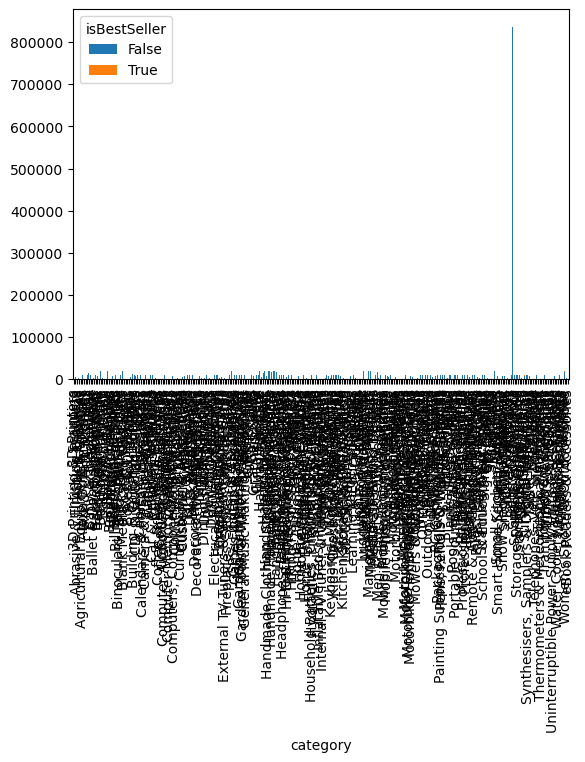

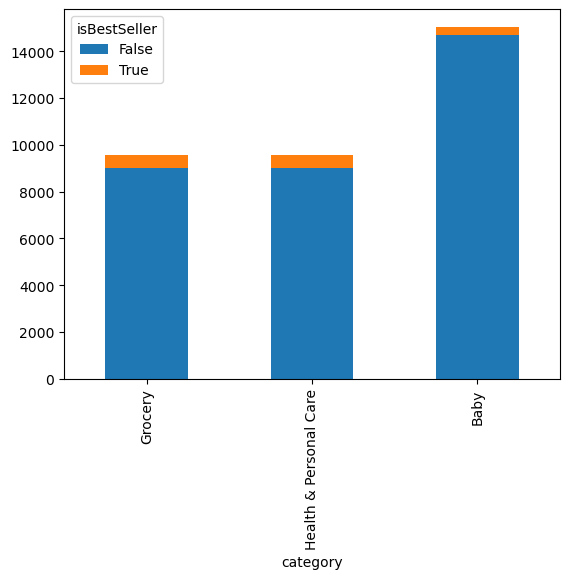

In [77]:
# 3. Visualization
crosstab_result.plot(kind="bar", stacked=True)

# just an example for actual visualization
crosstab_result.sort_values(by=True, ascending=False)[:3].plot(kind="bar", stacked=True)

**Part 2: Exploring Product Prices and Ratings Across Categories and Brands**

Objective: Investigate how different product categories influence product prices.

0. Preliminary Step: Remove outliers in product prices.

    For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

    Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

1. Violin Plots:

    - Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. Bar Charts:

    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. Box Plots:

    - Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [78]:
# 0
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

In [97]:
price_outliers=tukeys_test_outliers(df["price"])
price_outliers

10         139.00
19         164.99
25         149.99
28         289.00
31         199.99
            ...  
2443619    166.99
2443627    152.58
2443638    108.77
2443641    166.99
2443643    158.99
Name: price, Length: 327688, dtype: float64

In [98]:
# Filtering out the outliers based on the index of price_outliers
df_2= df[df.index.isin(price_outliers.index)==False]
df_2

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


C:\Users\ruijr\AppData\Local\Temp\ipykernel_1708\324241554.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_3, x='category', y='price', palette="coolwarm", order=list(id_20_cat.index) )


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Beauty'),
  Text(2, 0, 'Bath & Body'),
  Text(3, 0, 'Manicure & Pedicure Products'),
  Text(4, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(5, 0, 'Make-up'),
  Text(6, 0, 'Skin Care'),
  Text(7, 0, 'Hair Care'),
  Text(8, 0, 'Birthday Gifts'),
  Text(9, 0, 'Handmade Gifts'),
  Text(10, 0, 'Handmade Home Décor'),
  Text(11, 0, 'Luggage and travel gear'),
  Text(12, 0, 'Women'),
  Text(13, 0, 'Fragrances'),
  Text(14, 0, 'Handmade Kitchen & Dining'),
  Text(15, 0, 'Handmade Artwork'),
  Text(16, 0, 'Handmade Home & Kitchen Products'),
  Text(17, 0, 'Handmade Jewellery'),
  Text(18, 0, 'Men'),
  Text(19, 0, 'Baby')])

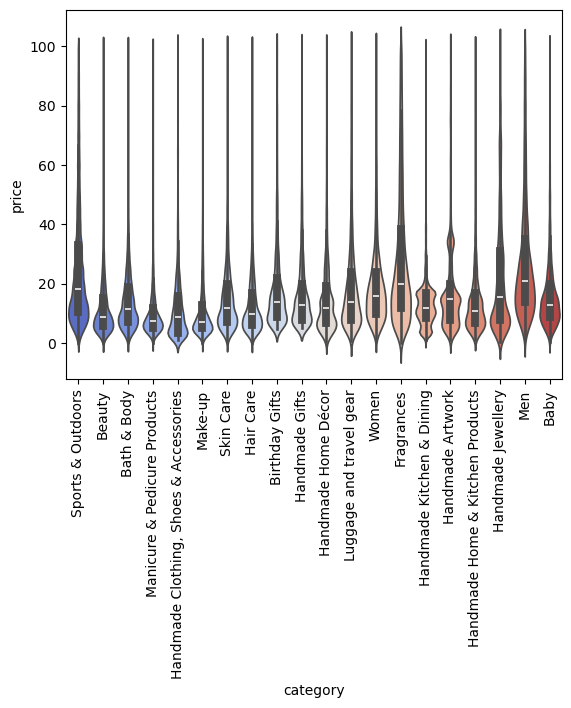

In [140]:
# 1. Violin Plots

id_20_cat=df_2.groupby("category").agg({"price":"count"}).rename(columns={"price":"count"}).sort_values(by="count",ascending=False)[0:20]
# id_20_cat.index
df_3=df_2[df_2["category"].isin(id_20_cat.index)]

sns.violinplot(data=df_3, x='category', y='price', palette="coolwarm", order=list(id_20_cat.index) )
plt.xticks(rotation=90)

In [167]:
df_2.groupby("category").agg({"price":"median"}).rename(columns={"price":"median_price"}).sort_values(by="median_price",ascending=False)
# Desktop PC's tend to have the highest median value

,median_price
category,
Desktop PCs,74.00
Boxing Shoes,69.79
Tablets,69.00
Graphics Cards,68.54
Motherboards,67.92
...,...
Adapters,7.05
Make-up,7.00
Signs & Plaques,6.99


C:\Users\ruijr\AppData\Local\Temp\ipykernel_1708\1441282282.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_2[df_2["category"].isin(id_10_cat.index)], x='category', y='price', palette="coolwarm",order=list(id_10_cat.index))


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Beauty'),
  Text(2, 0, 'Bath & Body'),
  Text(3, 0, 'Manicure & Pedicure Products'),
  Text(4, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(5, 0, 'Make-up'),
  Text(6, 0, 'Skin Care'),
  Text(7, 0, 'Hair Care'),
  Text(8, 0, 'Birthday Gifts'),
  Text(9, 0, 'Handmade Gifts')])

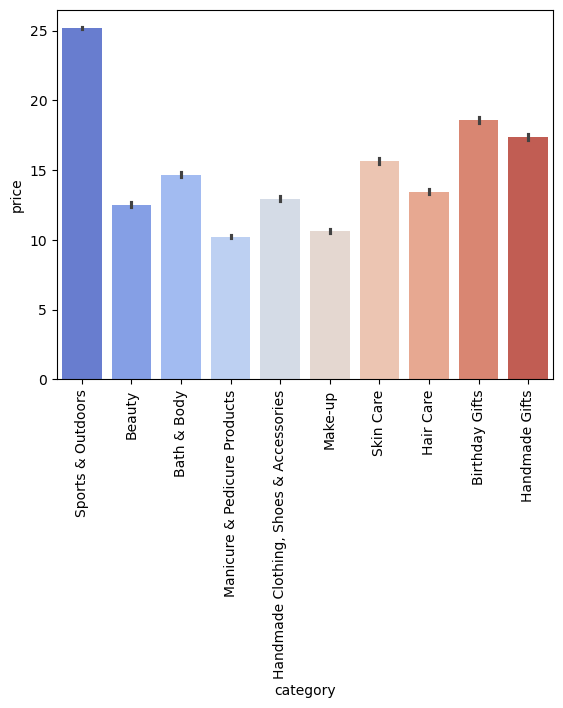

In [146]:
# 2. Bar Charts
id_10_cat=id_20_cat[0:10]
id_10_cat
sns.barplot(data=df_2[df_2["category"].isin(id_10_cat.index)], x='category', y='price', palette="coolwarm",order=list(id_10_cat.index))
plt.xticks(rotation=90)

In [166]:
df_2.groupby("category").agg({"price":"mean"}).rename(columns={"price":"mean_price"}).sort_values(by="mean_price",ascending=False)
# Motherboards tend to have the highest mean value

,mean_price
category,
Motherboards,68.772432
Boxing Shoes,67.417803
Desktop PCs,66.915562
Tablets,66.552971
Graphics Cards,65.103509
...,...
Bedding Accessories,8.835220
Adapters,8.750197
Signs & Plaques,8.210513


C:\Users\ruijr\AppData\Local\Temp\ipykernel_1708\2982970786.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_2[df_2["category"].isin(id_10_cat.index)], x='category', y='stars', palette="coolwarm",order=list(id_10_cat.index))


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Beauty'),
  Text(2, 0, 'Bath & Body'),
  Text(3, 0, 'Manicure & Pedicure Products'),
  Text(4, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(5, 0, 'Make-up'),
  Text(6, 0, 'Skin Care'),
  Text(7, 0, 'Hair Care'),
  Text(8, 0, 'Birthday Gifts'),
  Text(9, 0, 'Handmade Gifts')])

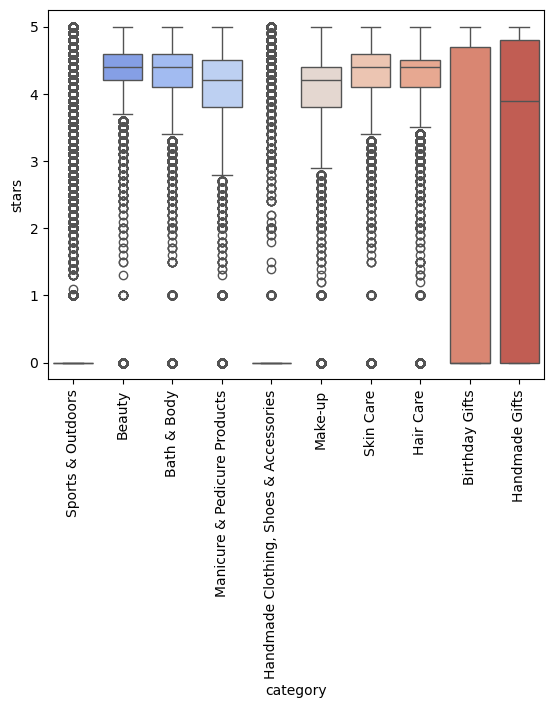

In [155]:
# 3. Box Plots
sns.boxplot(data=df_2[df_2["category"].isin(id_10_cat.index)], x='category', y='stars', palette="coolwarm",order=list(id_10_cat.index))
plt.xticks(rotation=90)

In [165]:
df_2.groupby("category").agg({"stars":"median"}).rename(columns={"stars":"median_stars"}).sort_values(by="median_stars",ascending=False)
# Computer Memory tends to have the highest median rating


,median_stars
category,
Computer Memory,4.7
Building & Construction Toys,4.6
Office Paper Products,4.6
Luxury Food & Drink,4.6
Kids' Play Figures,4.6
...,...
Hockey Shoes,0.0
Hi-Fi Receivers & Separates,0.0
Handmade Kitchen & Dining,0.0


**Part 3: Investigating the Interplay Between Product Prices and Ratings**

Objective: Analyze how product ratings (stars) correlate with product prices.

1. Correlation Coefficients:

    - Calculate the correlation coefficient between price and stars.
    - Is there a significant correlation between product price and its rating?

2. Visualizations:

    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot.

In [193]:
# 1.
correlation_pearson = df_2['price'].corr(df_2['stars'], method = "pearson")
correlation_spearman = df_2['price'].corr(df_2['stars'], method = "spearman")

print(f"""Pearson's correlation: {correlation_pearson},
Spearman's correlation: {correlation_spearman}""")

Pearson's correlation: -0.07767299878181323,
Spearman's correlation: -0.06679697280768307


In [174]:
#- The Pearson correlation of -0.08 suggests a weak negative linear relationship between the price and rating.
#- The Spearman correlation of -0.07 indicates a weak negative monotonic relationship between the price and rating.

<Axes: xlabel='price', ylabel='stars'>

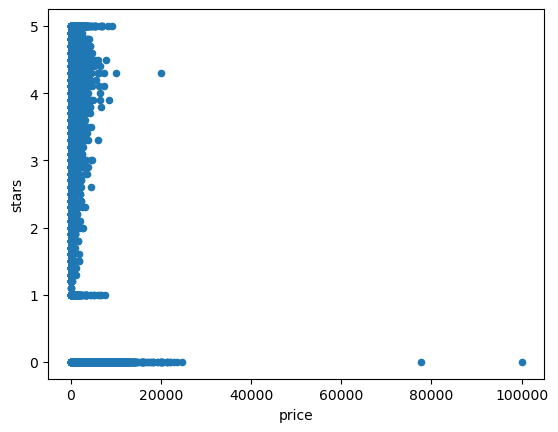

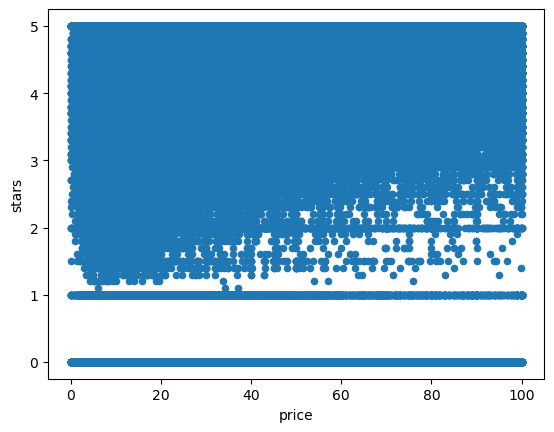

In [177]:
# 2. 
df_2.plot(kind="scatter", x="price", y="stars")

In [ ]:
# there are no visible patters between price and ratings

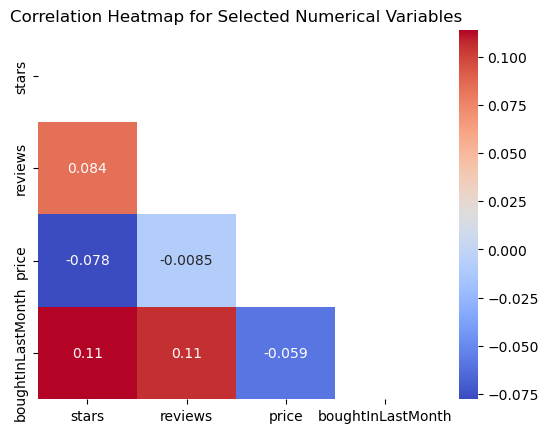

In [192]:
correlation_matrix = df_2.select_dtypes("number").drop(columns="uid").corr()

# Setting up the matplotlib figure with an appropriate size
# plt.figure(figsize=(10, 12))

mask = np.triu(correlation_matrix)  # just to show half the matrix
# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", mask=mask)

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

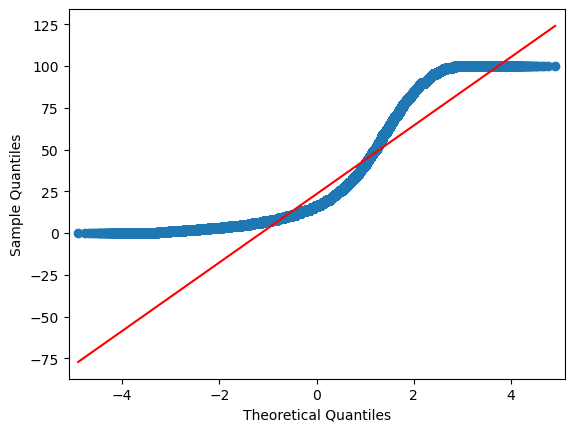

In [191]:
sm.qqplot(df_2['price'], line='s');

In [ ]:
# The price does not follow a normal distribution

**Bonus:**

Do the same analysis without taking out the outliers. What are your insights?